# **Ice Store Video Game Sales Analysis**

### **project description**
In this project my goal is to identify patterns that help determine a game's success to assist in planning campaigns for 2017. The dataset includes user and expert reviews, genres, platforms, sales, and the ESRB age rating. We will be using T-tests to specifically test 2 different hypothesis.

1.The average user ratings for the Xbox One and PC genres are the same

2.The average user ratings for the Action and Sports genres are different



## **1. Data Loading and Initial Exploration**

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from scipy import stats 
import seaborn as sns
import matplotlib.pyplot as plt

# load dataset
games_df = pd.read_csv('/datasets/games.csv')

# general information 
games_df.info()
display(games_df.head())
games_df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


## 2. data preparation

### 2.1 column names

In [2]:
# Convert column names to lowercase
games_df.columns = games_df.columns.str.lower()

# Display column names to confirm
games_df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### 2.2 data type convertion

In [3]:
# converting User scores to float64
games_df['user_score'] = pd.to_numeric(games_df['user_score'], errors='coerce')
games_df['year_of_release'] = pd.to_numeric(games_df['year_of_release'], errors='coerce').astype('Int64')


Here i used to_numeric to convert and also converted all the tbd cells to  nan so it wont effect analysis.

also changed 'year_of_release' to int for esthetics when graphing. had to do to numeric first because astype doesn't support errors='coerce'

### 2.3 Missing Values

In [4]:
# check for missing values 

# droping name and year of release nan data
games_df = games_df.dropna(subset=['name'])
games_df = games_df.dropna(subset=['year_of_release'])

# using transform to do the same with 'rating'
games_df['rating'] = games_df.groupby('genre')['rating'].fillna('unknown')

games_df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         8981
rating                0
dtype: int64

I delt with the missing values in 2 main ways 

* name and year of release was not substantial enough so i removed the rows

* the rating i decided to take the missing values and make them 'unknown'

### 2.4 calculation total sales

In [5]:
# adding total sales column
games_df['total_sales'] = games_df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
display(games_df.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


Adding a total sales column will help with later analysis

## 3. Data Analysis

### 3.1 Games Released Over the Years

<AxesSubplot:title={'center':'Games Released Per Year'}>

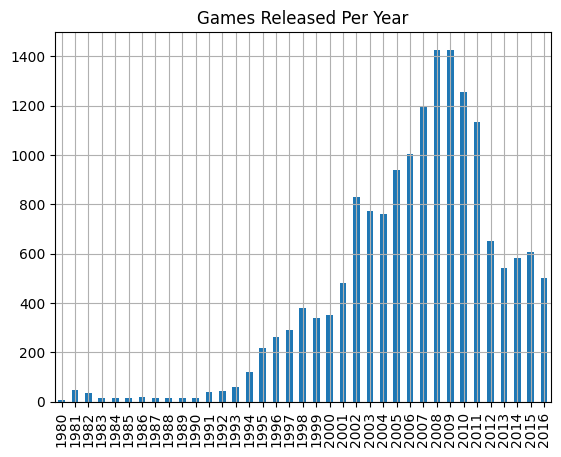

In [6]:
# how many games were released each year
games_per_year = games_df['year_of_release'].value_counts().sort_index()
games_per_year.plot(kind='bar', title='Games Released Per Year', grid=True)


The most games were released in 2008-2009. Games released per year before 1995 is negligible 

### 3.2 Sales by platform

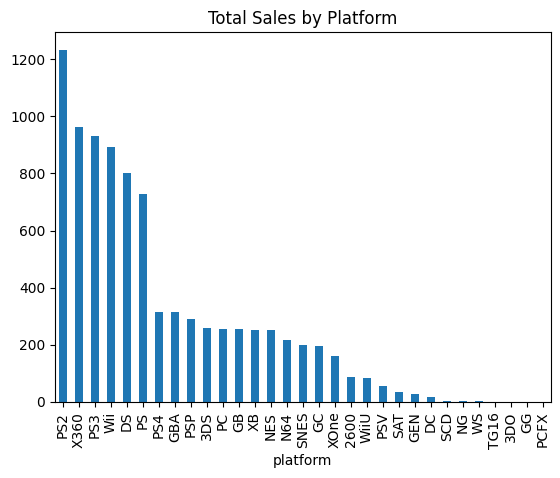

In [7]:
#calculating total sales
platform_sales = games_df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
platform_sales.plot(kind='bar', title='Total Sales by Platform')

# Choose platforms with greatest total sales
top_platforms = platform_sales.head(5).index

# Filter data for top platforms
top_platforms_df = games_df[games_df['platform'].isin(top_platforms)]


the sales are the greatest for the ps2 then the xbox360 and then the ps3.

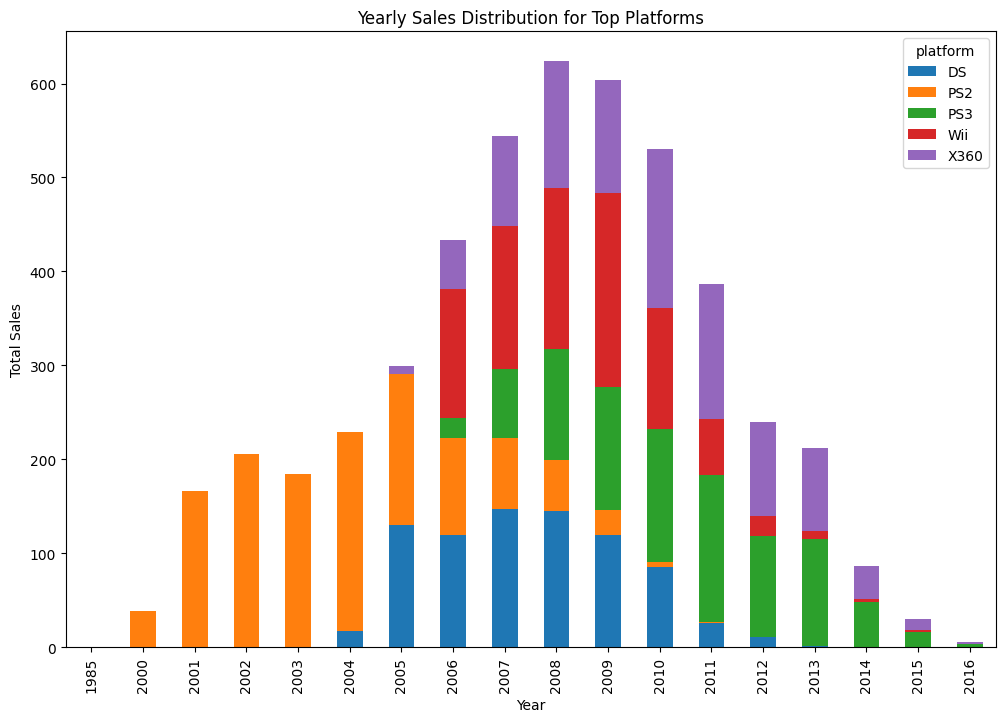

In [8]:
# Group by year and platform
yearly_sales = top_platforms_df.groupby(['year_of_release', 'platform'])['total_sales'].sum().unstack()

# Plot the distribution of sales for each year
yearly_sales.plot(kind='bar', stacked=True, figsize=(12, 8), title='Yearly Sales Distribution for Top Platforms')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.show()

The top platforms all preform in the 2000 - 2016 area and all have a relatively smiler distribution all lasting around 10 years and all peaking in sales then diminish in a bell curve. 

In [9]:
# Calculate sales over time for each platform
platform_sales_over_time = games_df.groupby(['platform', 'year_of_release'])['total_sales'].sum().unstack().fillna(0)

# Identify platforms that had sales but now have zero sales in the latest year
latest_year = platform_sales_over_time.columns.max()
platforms_with_zero_sales = platform_sales_over_time[(platform_sales_over_time.sum(axis=1) > 0) & (platform_sales_over_time[latest_year] == 0)].index

print("Platforms with Zero Sales:", platforms_with_zero_sales.tolist())


Platforms with Zero Sales: ['2600', '3DO', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG', 'N64', 'NES', 'NG', 'PCFX', 'PS', 'PS2', 'PSP', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'XB']


the platforms in the list above have no sales as of the curent year. 

Average Lifespan of Platforms (after exclusion): 6.103448275862069


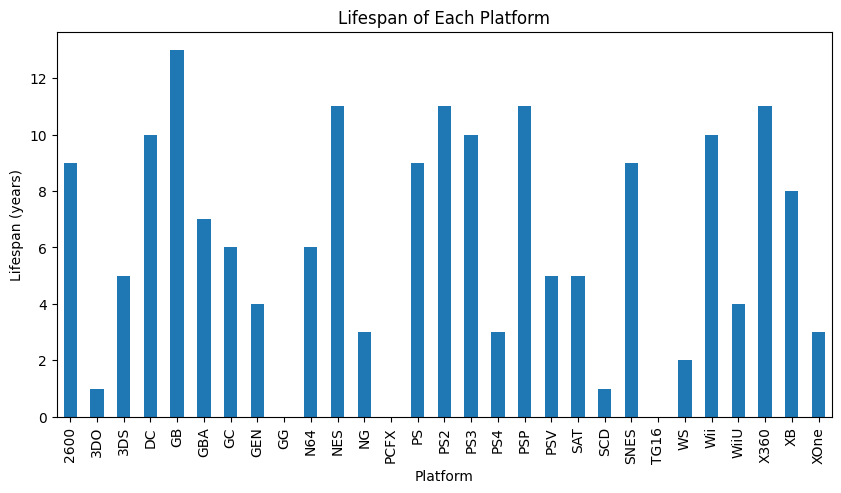

In [10]:
# Exclude 'DS' and 'PC' platforms
filtered_platform_sales_over_time = platform_sales_over_time.drop(['DS', 'PC'], errors='ignore')

# Calculate the first and last year of sales for each platform
filtered_platform_years = filtered_platform_sales_over_time.apply(lambda x: x[x > 0].index, axis=1)

# Calculate the lifespan by subtracting the first year from the last year
filtered_platform_lifespan = filtered_platform_years.apply(lambda years: years.max() - years.min() if len(years) > 0 else 0)

# Display the average lifespan after excluding platforms
average_lifespan_after = filtered_platform_lifespan.mean()
print("Average Lifespan of Platforms (after exclusion):", average_lifespan_after)

# Plotting the lifespan of each platform excluding 'DS' and 'PC'
filtered_platform_lifespan.plot(kind='bar', title='Lifespan of Each Platform', figsize=(10, 5))
plt.xlabel('Platform')
plt.ylabel('Lifespan (years)')
plt.show()


As we can see the average life span of a platform is 6 years. The outliers being the ds and PC so they are excluded from the average. PC is still a platform because of its versatility and will most likely always stay alive. The DS will need further investigation.
With this information we can say that the relevant years to our data would be in the previous 6 years from 2017. so going forward we will only look at 2010 and on.

In [11]:
# Filter the DataFrame for data from 2010 onwards
after_2010_df = games_df[games_df['year_of_release'] >= 2010]

display(after_2010_df.head())


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
14,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61.0,6.3,E,21.82
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
27,Pokemon Black/Pokemon White,DS,2010,Role-Playing,5.51,3.17,5.65,0.80,NaN,NaN,unknown,15.13
29,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,14.73


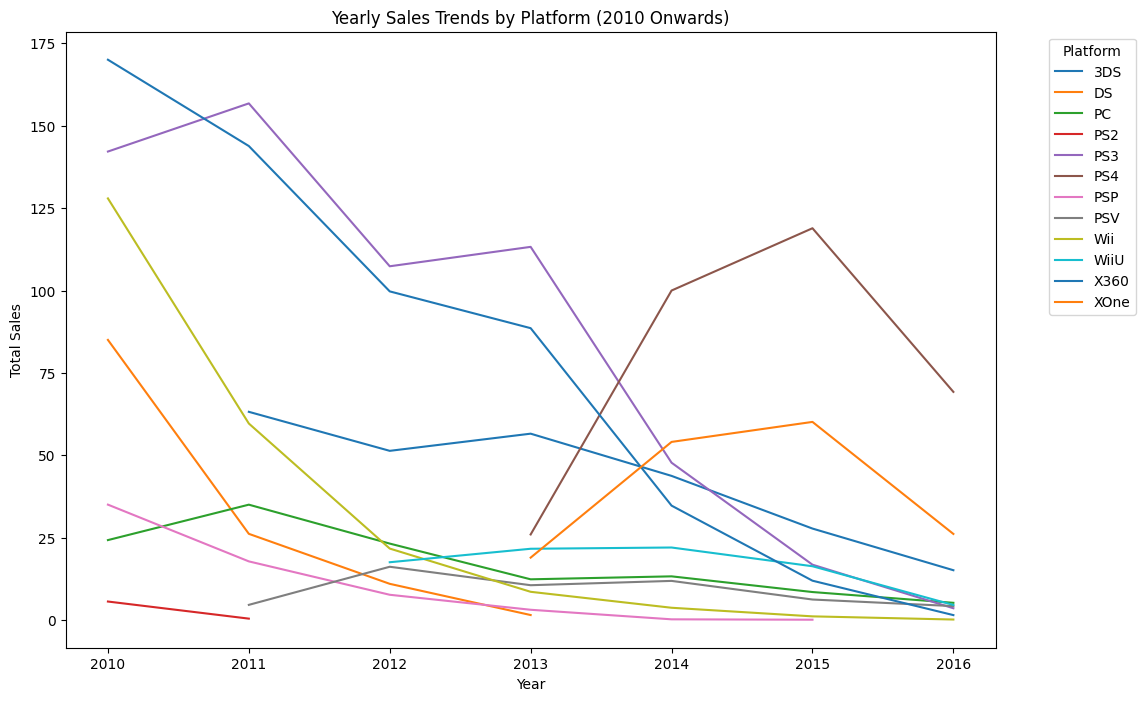

In [12]:
# Calculate yearly sales for each platform
platform_sales = after_2010_df.groupby(['year_of_release', 'platform'])['total_sales'].sum().unstack()

# line chart of yearly sales trends for each platform
platform_sales.plot(kind='line', figsize=(12, 8), title='Yearly Sales Trends by Platform (2010 Onwards)')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend(title='Platform', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()



Curently the ps4 is leading in sales with the xbox one behind. As the xbox one and ps4 came out the other consoles are gradualy moving to 0.

### 3.3 Box plot for global sales by platform

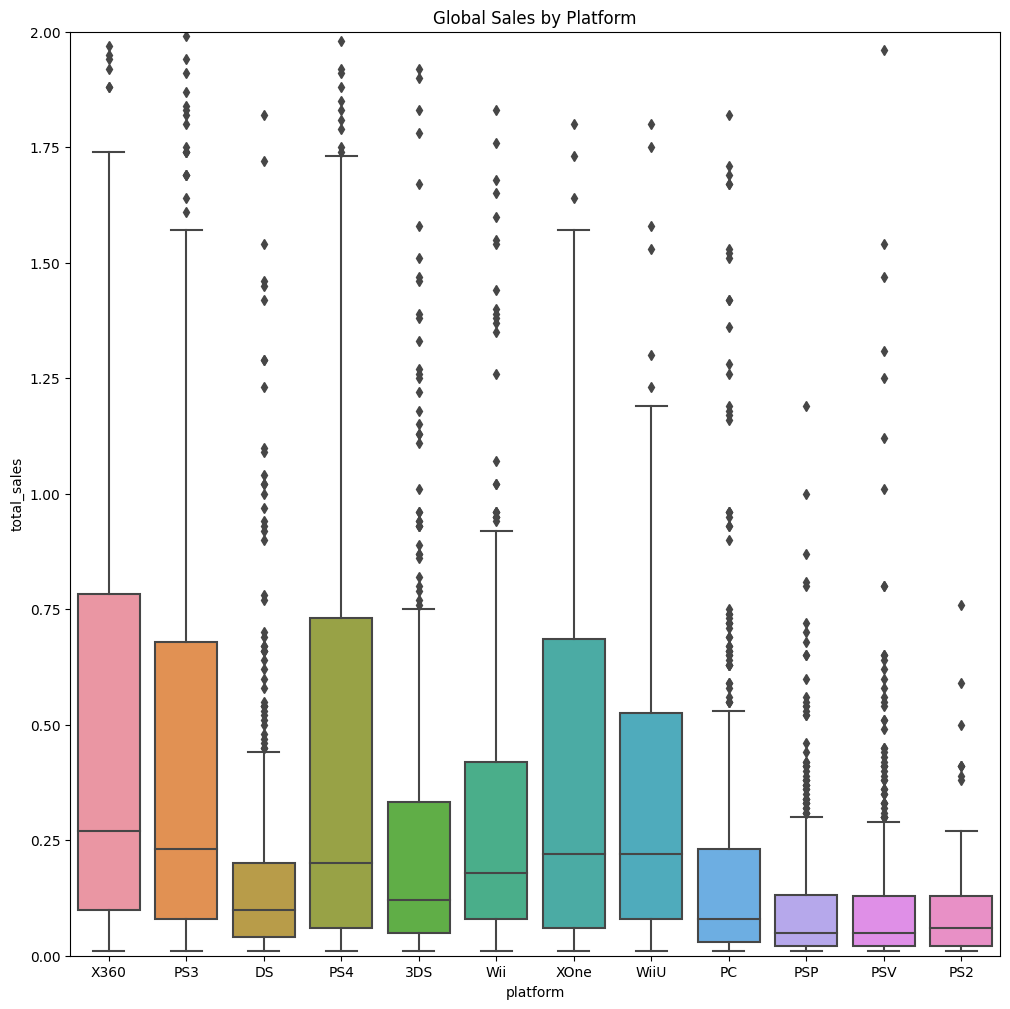

In [13]:
# boxplot
plt.figure(figsize=(12, 12))
sns.boxplot(data=after_2010_df, x='platform', y='total_sales')
plt.title('Global Sales by Platform')
plt.ylim(0,2)
plt.show()

This box plot shows us the x360, ps3, ps4, and XOne all have simmaler ranges.

### 3.5 Review coralation with sales

In [14]:
# PS4 platform
ps4_df = after_2010_df[after_2010_df['platform'] == 'PS4']

# Fixing user_score
ps4_df['user_score'] = ps4_df['user_score'] * 10
display(ps4_df)

/tmp/ipykernel_103/2696777672.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps4_df['user_score'] = ps4_df['user_score'] * 10


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,83.0,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,43.0,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,7.98
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,57.0,M,7.66
...,...,...,...,...,...,...,...,...,...,...,...,...
16500,Root Letter,PS4,2016,Adventure,0.00,0.00,0.01,0.00,69.0,75.0,unknown,0.01
16503,Shin Hayarigami 2,PS4,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown,0.01
16526,Dungeons 2,PS4,2016,Role-Playing,0.01,0.00,0.00,0.00,61.0,79.0,T,0.01
16530,Carmageddon: Max Damage,PS4,2016,Action,0.01,0.00,0.00,0.00,51.0,55.0,M,0.01


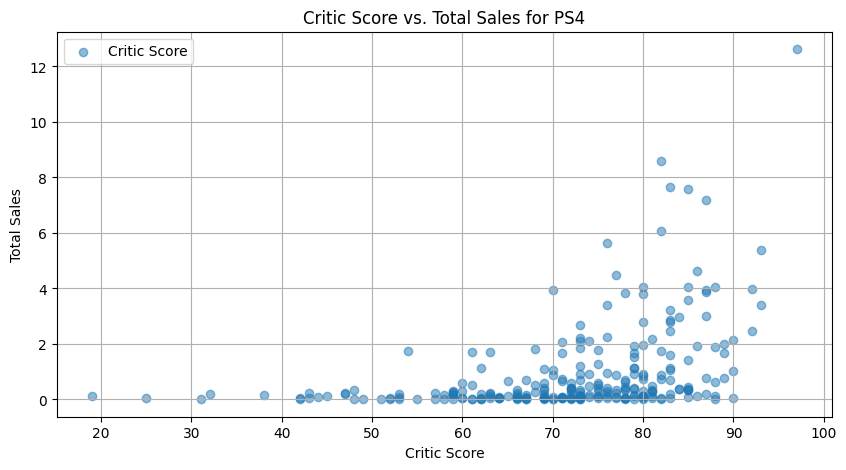

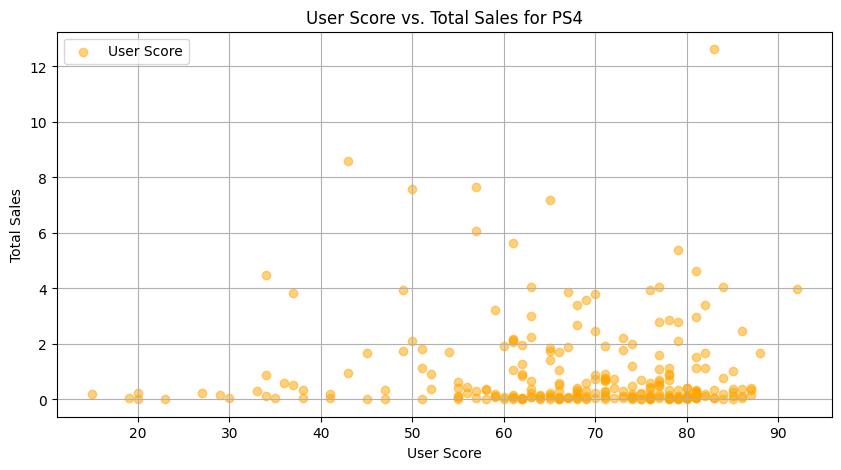

In [15]:

# critic score vs. total sales
plt.figure(figsize=(10, 5))
plt.scatter(ps4_df['critic_score'], ps4_df['total_sales'], alpha=0.5, label='Critic Score')
plt.xlabel('Critic Score')
plt.ylabel('Total Sales')
plt.title('Critic Score vs. Total Sales for PS4')
plt.legend()
plt.grid(True)
plt.show()

# user score vs. total sales
plt.figure(figsize=(10, 5))
plt.scatter(ps4_df['user_score'], ps4_df['total_sales'], alpha=0.5, color='orange', label='User Score')
plt.xlabel('User Score')
plt.ylabel('Total Sales')
plt.title('User Score vs. Total Sales for PS4')
plt.legend()
plt.grid(True)
plt.show()


It looks like critic scores are slightly more important for sales than user scores because we have a lot more outliers in the user score that have low score but high sales. The majority of games are rated between 60 and 90 and the majority of games don't make more than 2 million in sales. 

In [16]:
# Calculate the correlation between reviews and sales
critic_correlation = ps4_df['critic_score'].corr(ps4_df['total_sales'])
user_correlation = ps4_df['user_score'].corr(ps4_df['total_sales'])

print("Correlation of Critic Score vs Total Sales for PS4:", critic_correlation)
print("Correlation of User Score vs Total Sales for PS4:", user_correlation)


Correlation of Critic Score vs Total Sales for PS4: 0.40656790206178095
Correlation of User Score vs Total Sales for PS4: -0.031957110204556445


The corelation of sales vs Critic scores are around 35% this mean that the critic scores have an influence of game sales but the corelation of sales vs user score has close to no corelation if not a slight negative corelation. This means user scores are not a reliable source for predicting sales. critic scores is more likely to predict outcomes or influence sales.

### ps4 vs xbox one

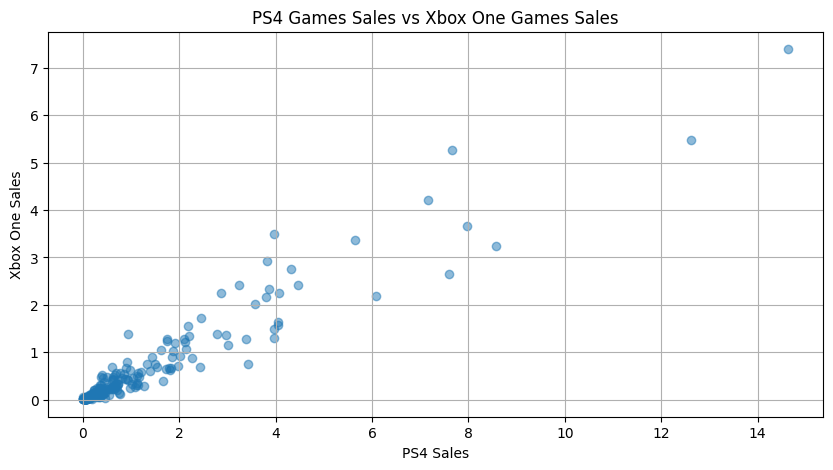

In [17]:
# Filter the DataFrame for PS4 and Xbox One platforms
ps4_df = after_2010_df[after_2010_df['platform'] == 'PS4'][['name', 'total_sales']].rename(columns={'total_sales': 'ps4_sales'})
xone_df = after_2010_df[after_2010_df['platform'] == 'XOne'][['name', 'total_sales']].rename(columns={'total_sales': 'xone_sales'})

# Merge the DataFrames on the 'name' column to align PS4 and Xbox One sales for the same games
merged_df = pd.merge(ps4_df, xone_df, on='name', how='inner')

# Scatter plot of PS4 vs Xbox One total sales
plt.figure(figsize=(10, 5))
plt.scatter(merged_df['ps4_sales'], merged_df['xone_sales'], alpha=0.5)
plt.xlabel('PS4 Sales')
plt.ylabel('Xbox One Sales')
plt.title('PS4 Games Sales vs Xbox One Games Sales')
plt.grid(True)
plt.show()


In [18]:
# Calculate the number of games that sell better on each platform
ps4_better_count = (merged_df['ps4_sales'] > merged_df['xone_sales']).sum()
xone_better_count = (merged_df['xone_sales'] > merged_df['ps4_sales']).sum()
total_games = merged_df.shape[0]

# Calculate the percentage
ps4_better_percentage = (ps4_better_count / total_games) * 100
xone_better_percentage = (xone_better_count / total_games) * 100

print("Percentage of games that sell better on PS4:", ps4_better_percentage)
print("Percentage of games that sell better on Xbox One:", xone_better_percentage)


Percentage of games that sell better on PS4: 93.08755760368663
Percentage of games that sell better on Xbox One: 3.225806451612903


In [19]:
# Create a pivot table with games as rows and platforms as columns
platform_sales_pivot = after_2010_df.pivot_table(index='name', columns='platform', values='total_sales', fill_value=0)

# Determine the platform with the highest sales for each game
platform_max_sales = platform_sales_pivot.idxmax(axis=1)

# Calculate the percentage of games that sell best on each platform
platform_best_sales_percentage = platform_max_sales.value_counts(normalize=True) * 100
print(platform_best_sales_percentage)


PS3     15.996344
3DS     13.101767
DS      12.949421
PSP     12.888483
Wii      9.414991
PS4      9.018891
PSV      8.744668
X360     7.921999
PC       6.611822
WiiU     1.736746
XOne     1.005484
PS2      0.609385
dtype: float64


This data suggests that PlayStation platforms, particularly the PS3, have dominated sales in this context, with significant contributions from Nintendo's handhelds. The Xbox platforms and some other consoles like the Wii U have comparatively lower sales proportions. This needs to be investigated further to gain more insight to why and how this may help.

### distrabution of games by genre

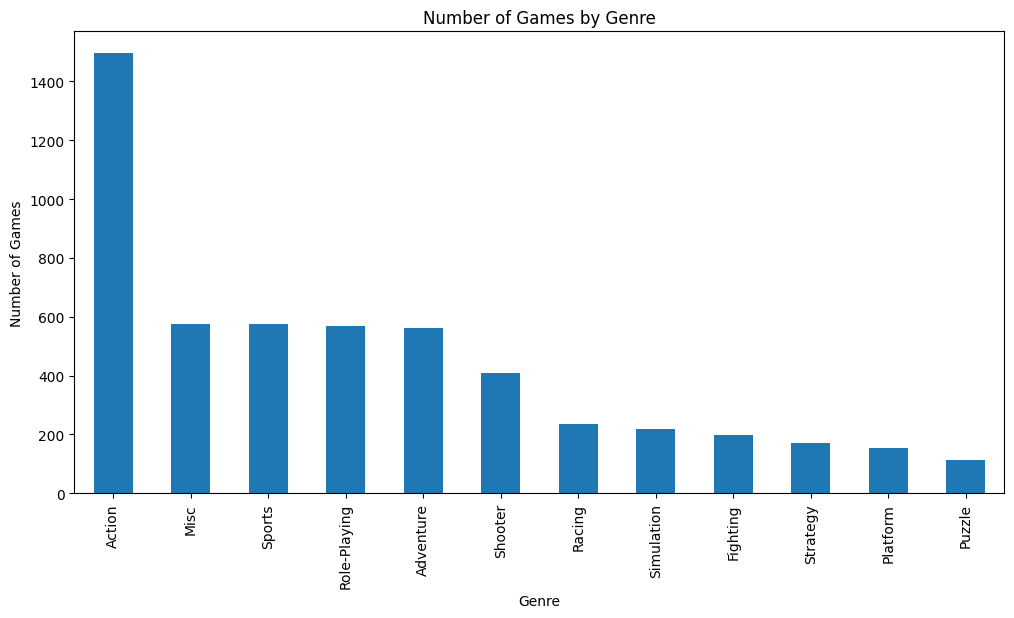

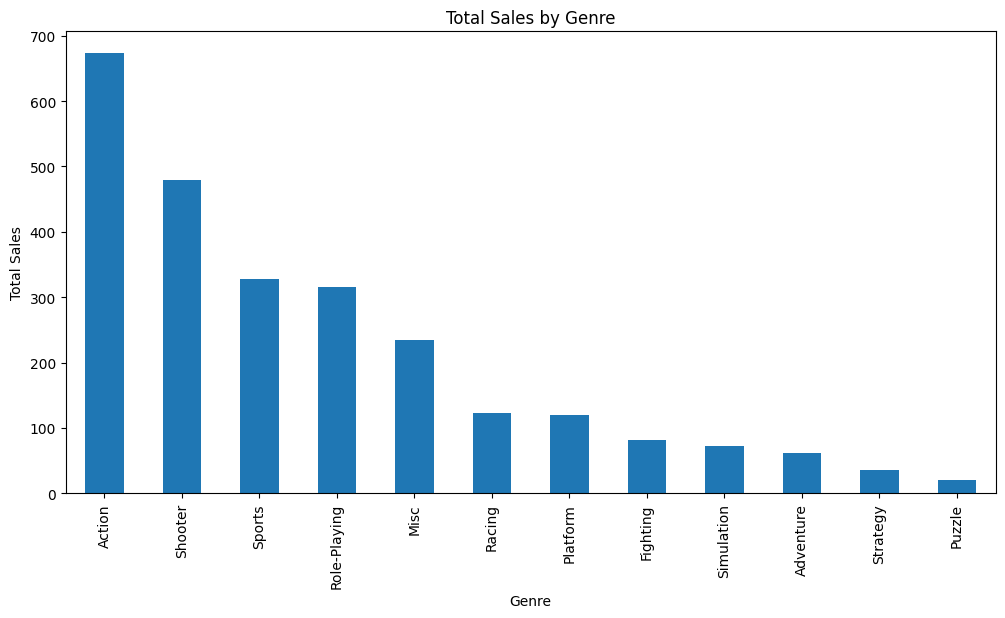

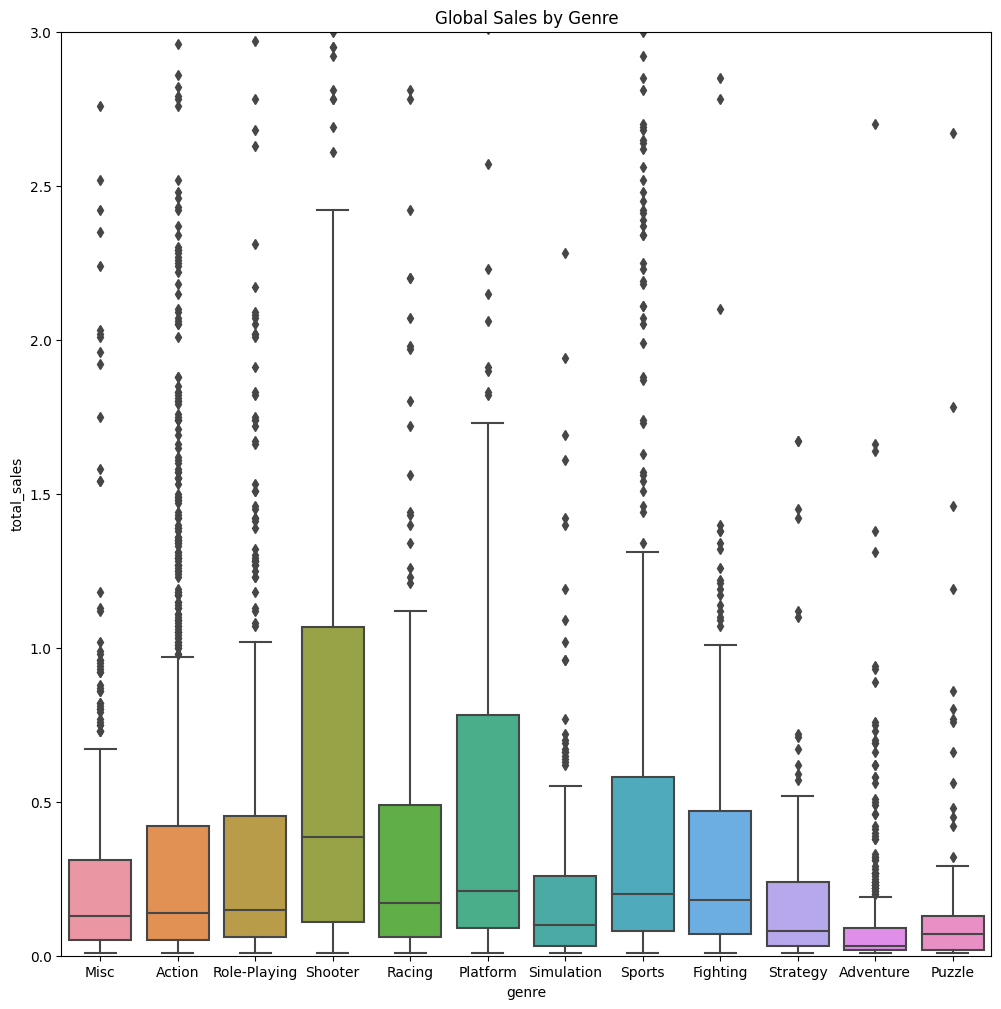

In [20]:
# number of games in each genre
genre_counts = after_2010_df['genre'].value_counts()

# Plot the distribution of games by genre
genre_counts.plot(kind='bar', figsize=(12, 6), title='Number of Games by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Games')
plt.show()

# Calculate total sales for each genre
total_sales_by_genre = after_2010_df.groupby('genre')['total_sales'].sum().sort_values(ascending=False)

# Plot total sales by genre
total_sales_by_genre.plot(kind='bar', figsize=(12, 6), title='Total Sales by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Sales')
plt.show()

# boxplot
plt.figure(figsize=(12, 12))
sns.boxplot(data=after_2010_df, x='genre', y='total_sales')
plt.title('Global Sales by Genre')
plt.ylim(0,3)
plt.show()


action games by far have the highest density of games and the highest total sales. The interesting thing to pull from these graphs is that shooter games even though they don't have a large density have a high total sales. This tells us that shooter games do very well with a lower diversity. 

## 4. Regional User Profile Analysis

### 4.1 top platforms by region 

Top Five Platforms in NA:
platform
X360    334.18
PS3     229.25
Wii     121.20
PS4     108.74
XOne     93.12
Name: na_sales, dtype: float64

Top Five Platforms in EU:
platform
PS3     213.60
X360    163.41
PS4     141.09
PC       68.82
Wii      65.91
Name: eu_sales, dtype: float64

Top Five Platforms in JP:
platform
3DS    100.62
PS3     59.26
PSP     42.20
DS      27.90
PSV     21.84
Name: jp_sales, dtype: float64


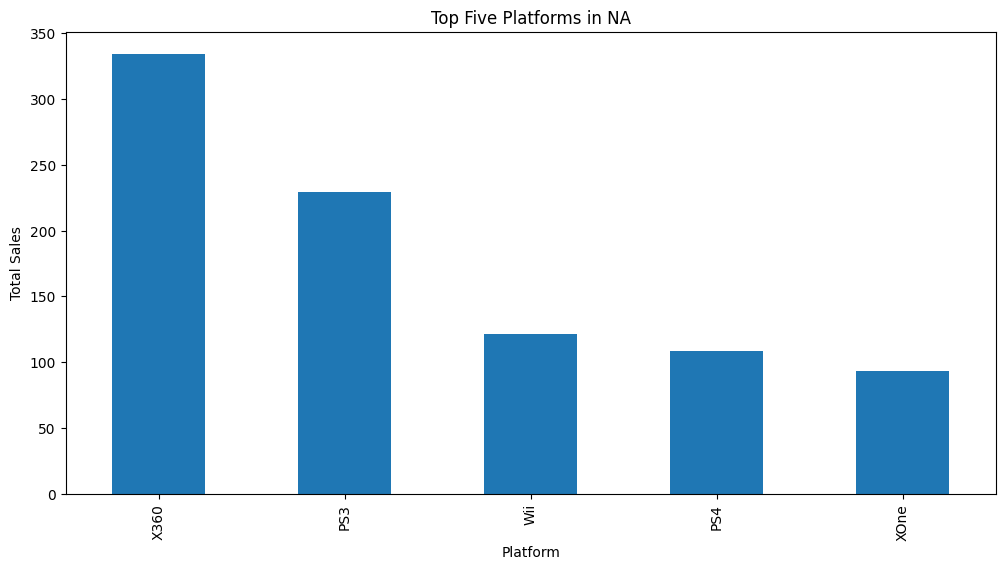

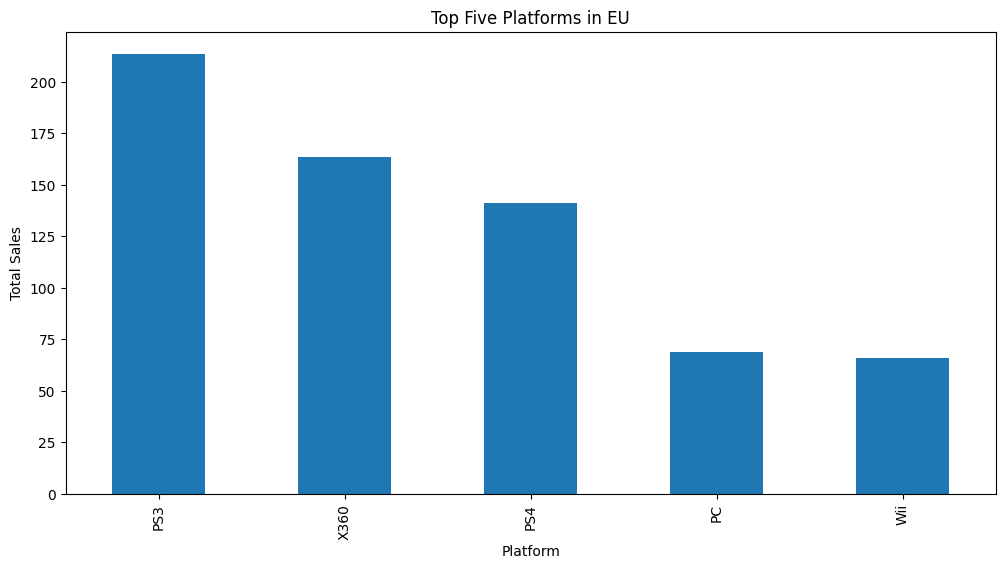

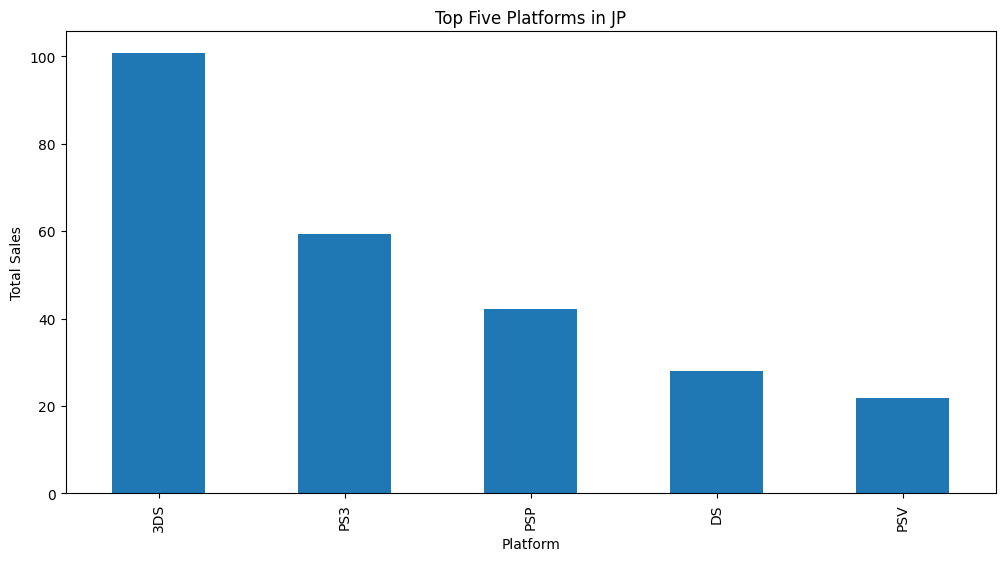

In [21]:
# Calculate total sales for each platform in each region
top_platforms_na = after_2010_df.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(5)
top_platforms_eu = after_2010_df.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(5)
top_platforms_jp = after_2010_df.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(5)

print("Top Five Platforms in NA:")
print(top_platforms_na)
print("\nTop Five Platforms in EU:")
print(top_platforms_eu)
print("\nTop Five Platforms in JP:")
print(top_platforms_jp)

# Plotting the results
top_platforms_na.plot(kind='bar', figsize=(12, 6), title='Top Five Platforms in NA')
plt.xlabel('Platform')
plt.ylabel('Total Sales')
plt.show()

top_platforms_eu.plot(kind='bar', figsize=(12, 6), title='Top Five Platforms in EU')
plt.xlabel('Platform')
plt.ylabel('Total Sales')
plt.show()

top_platforms_jp.plot(kind='bar', figsize=(12, 6), title='Top Five Platforms in JP')
plt.xlabel('Platform')
plt.ylabel('Total Sales')
plt.show()

Here we can see NA and EU have about the same amount of sales when it comes to the ps 3. the main difference between NA and EU is that the xbox 360 dominates the market in NA. In JP the market is more catered to hand held platforms vs consoles. 

### 4.2 Top Genres by Region

Top Five genre in NA:
genre
Action          290.64
Shooter         237.47
Sports          156.81
Misc            123.80
Role-Playing    112.05
Name: na_sales, dtype: float64

Top Five genre in EU:
genre
Action          233.63
Shooter         171.45
Sports          116.84
Role-Playing     75.48
Misc             66.09
Name: eu_sales, dtype: float64

Top Five genre in JP:
genre
Role-Playing    103.54
Action           72.20
Misc             24.29
Platform         15.81
Adventure        15.67
Name: jp_sales, dtype: float64


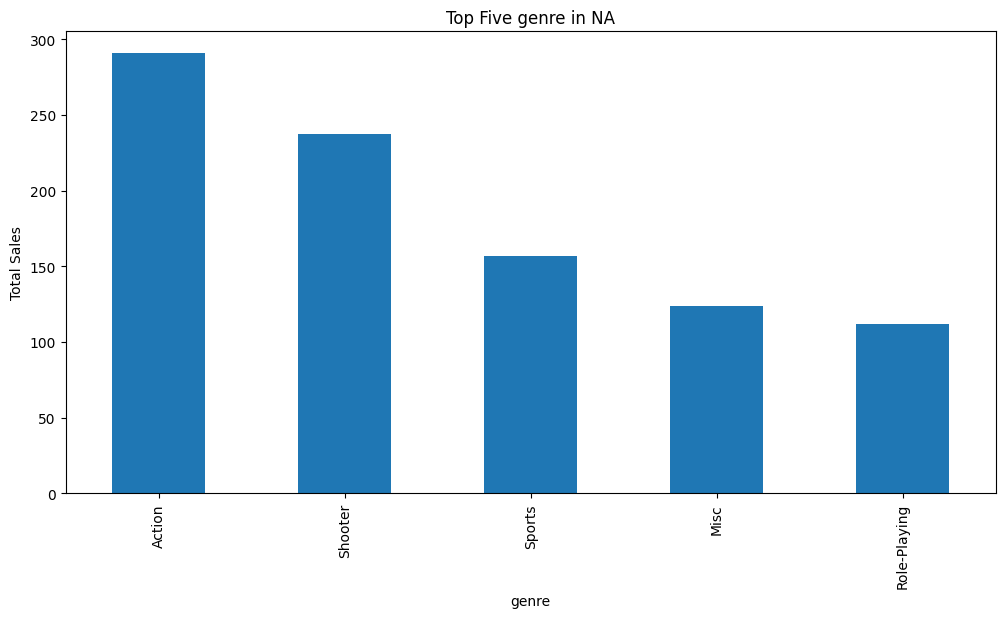

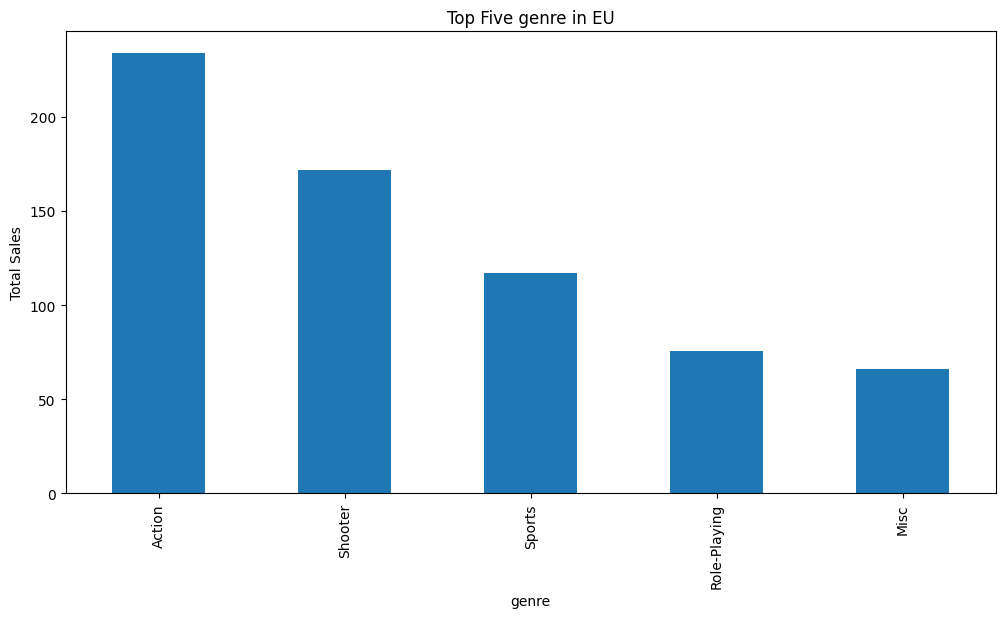

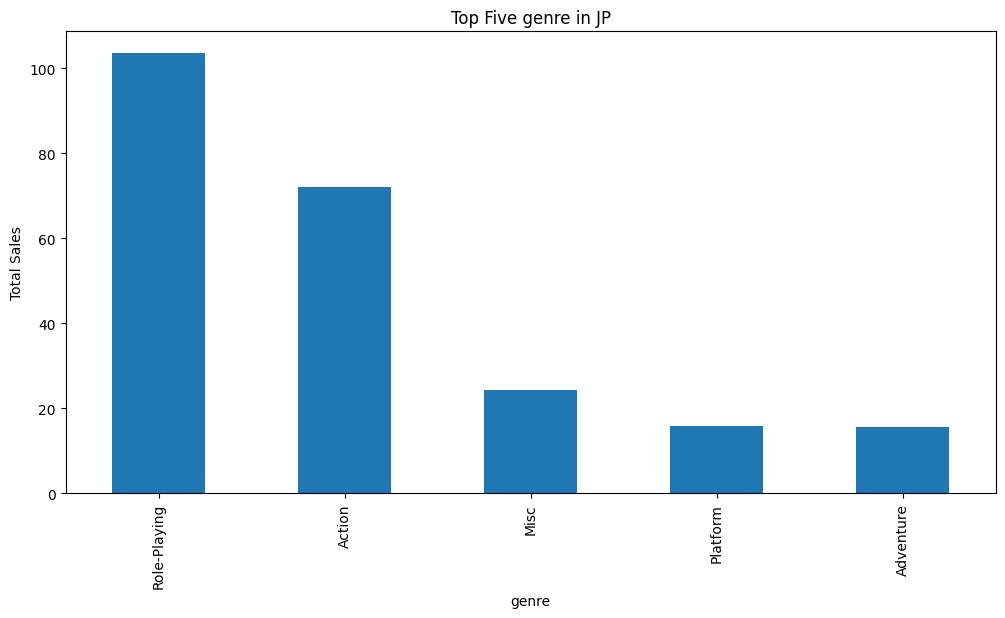

In [22]:
# Calculate total sales for each genre in each region
top_genre_na = after_2010_df.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(5)
top_genre_eu = after_2010_df.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5)
top_genre_jp = after_2010_df.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5)

print("Top Five genre in NA:")
print(top_genre_na)
print("\nTop Five genre in EU:")
print(top_genre_eu)
print("\nTop Five genre in JP:")
print(top_genre_jp)

# Plotting the results
top_genre_na.plot(kind='bar', figsize=(12, 6), title='Top Five genre in NA')
plt.xlabel('genre')
plt.ylabel('Total Sales')
plt.show()

top_genre_eu.plot(kind='bar', figsize=(12, 6), title='Top Five genre in EU')
plt.xlabel('genre')
plt.ylabel('Total Sales')
plt.show()

top_genre_jp.plot(kind='bar', figsize=(12, 6), title='Top Five genre in JP')
plt.xlabel('genre')
plt.ylabel('Total Sales')
plt.show()

Here we see that NA and EU are very smiler in sales by genre. The main thing to note here is that JP has a large focus on role playing games but all regions like action games. The JP genre revenue reflects its hand held market. 

### 4.3 ESRB Rating Influence 

Top Five rating in NA:
rating
M          382.22
E          271.15
T          160.81
E10+       159.38
unknown    155.72
Name: na_sales, dtype: float64

Top Five rating in EU:
rating
M          292.04
E          197.34
unknown    139.44
T          113.08
E10+        99.28
Name: eu_sales, dtype: float64

Top Five rating in JP:
rating
unknown    171.49
E           47.87
T           42.11
M           30.45
E10+        13.22
Name: jp_sales, dtype: float64


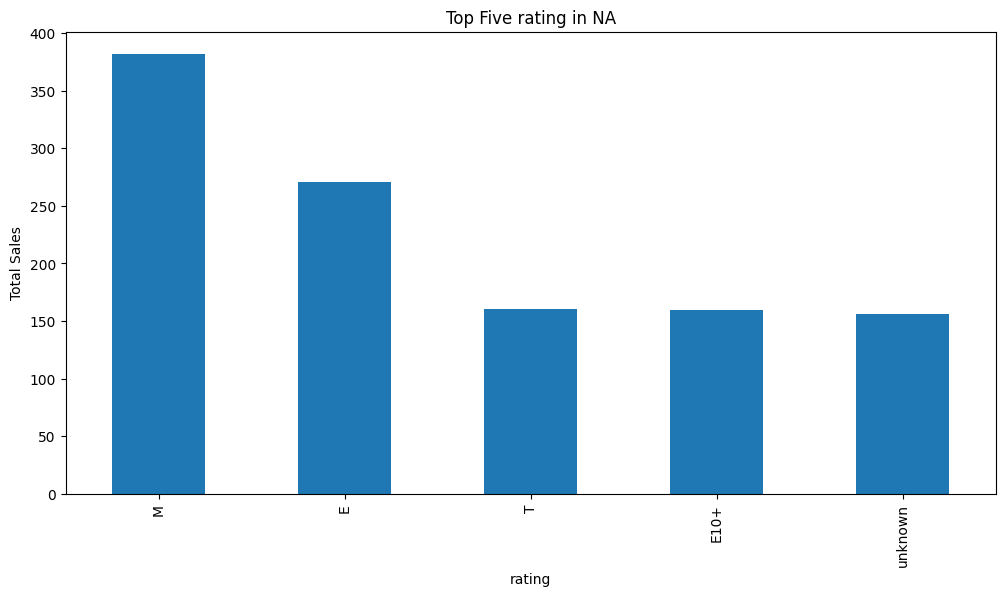

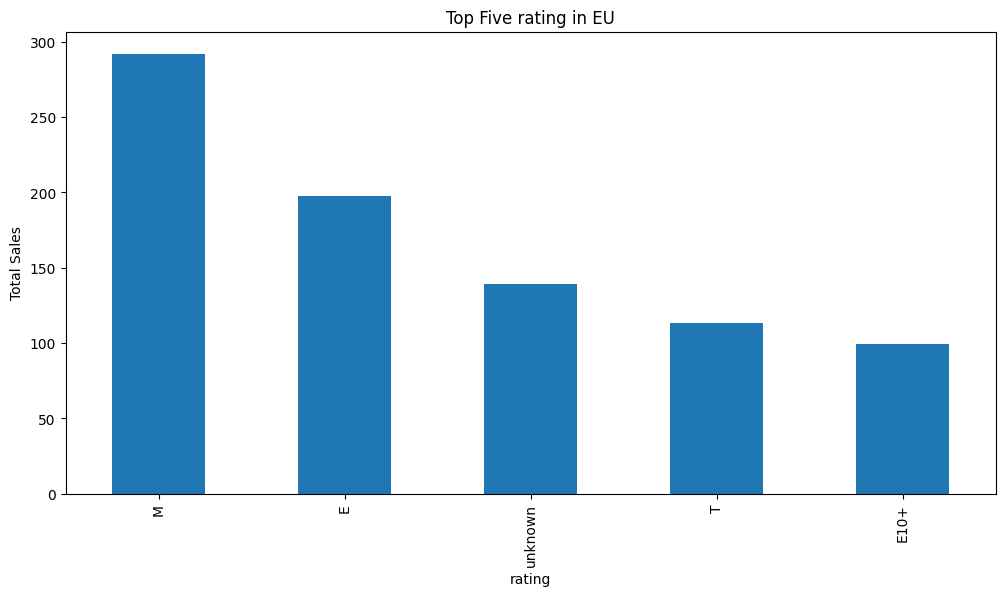

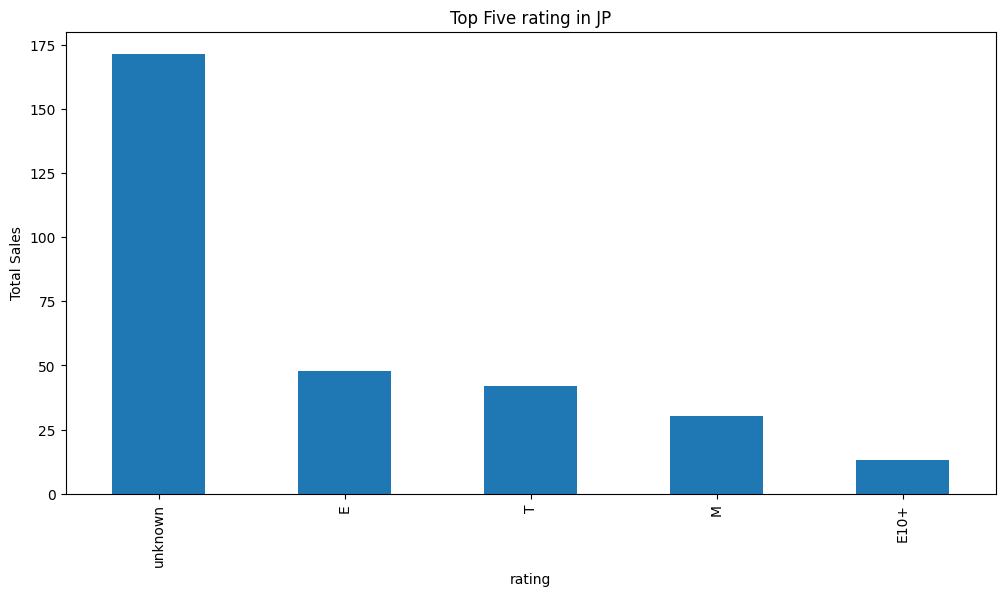

In [23]:
# Calculate total sales for each rating in each region
top_rating_na = after_2010_df.groupby('rating')['na_sales'].sum().sort_values(ascending=False).head(5)
top_rating_eu = after_2010_df.groupby('rating')['eu_sales'].sum().sort_values(ascending=False).head(5)
top_rating_jp = after_2010_df.groupby('rating')['jp_sales'].sum().sort_values(ascending=False).head(5)

print("Top Five rating in NA:")
print(top_rating_na)
print("\nTop Five rating in EU:")
print(top_rating_eu)
print("\nTop Five rating in JP:")
print(top_rating_jp)

# Plotting the results
top_rating_na.plot(kind='bar', figsize=(12, 6), title='Top Five rating in NA')
plt.xlabel('rating')
plt.ylabel('Total Sales')
plt.show()

top_rating_eu.plot(kind='bar', figsize=(12, 6), title='Top Five rating in EU')
plt.xlabel('rating')
plt.ylabel('Total Sales')
plt.show()

top_rating_jp.plot(kind='bar', figsize=(12, 6), title='Top Five rating in JP')
plt.xlabel('rating')
plt.ylabel('Total Sales')
plt.show()

The trend continues that the EU and NA market are relatively similar and the JP market being the exception. The main similarly between all three is that E rated games are still relatively popular though out. This might suggest The younger audience is driving this trend. The ratings of games in JP need to be further investigated because of the large amount of unknown ratings for games. 

## 5. Hypothesis Testing

### Hypothisis 1

In [24]:
# Filter scores
xbox_scores = after_2010_df[after_2010_df['platform'] == 'XOne']['user_score'].dropna()
pc_scores = after_2010_df[after_2010_df['platform'] == 'PC']['user_score'].dropna()

alpha = 0.05
# t-test
t_stat1, p_val1 = stats.ttest_ind(xbox_scores, pc_scores, equal_var=False)

# Output results
print("Hypothesis 1 Results:")
print("t-statistic:", t_stat1)
print("p-value:", p_val1)

if p_val1 < alpha:
    print("Reject the null hypothesis: The average user ratings for Xbox One and PC platforms are different.")
else:
    print("Fail to reject the null hypothesis: The average user ratings for Xbox One and PC platforms are the same.")



Hypothesis 1 Results:
t-statistic: 0.024879518331077908
p-value: 0.9801634129117883
Fail to reject the null hypothesis: The average user ratings for Xbox One and PC platforms are the same.


My hypothesis is that the average user ratings for the Xbox One and PC genres are the same.
This assumes that any observed differences in average user ratings are due to random chance and not because the genres differ in quality or preference.

### Hypothesis 2

In [25]:
# Filter user scores for Action One and Sports
action_scores = after_2010_df[after_2010_df['genre'] == 'Action']['user_score'].dropna()
sports_scores = after_2010_df[after_2010_df['genre'] == 'Sports']['user_score'].dropna()

# Set alpha
alpha = 0.05

# Comparing Action and Sports user ratings
t_stat1, p_val1 = stats.ttest_ind(xbox_scores, pc_scores, equal_var=False)

print("t-statistic:", t_stat1)
print("p-value:", p_val1)

if p_val1 < alpha:
    print("Reject the null hypothesis: The average user ratings for Action and Sports platforms are the same.")
else:
    print("Fail to reject the null hypothesis: The average user ratings for Action and Sports platforms are different.")

t-statistic: 0.024879518331077908
p-value: 0.9801634129117883
Fail to reject the null hypothesis: The average user ratings for Action and Sports platforms are different.


My hypothesis is that the average user ratings for the Action and Sports genres are different.
This assumes that any observed similarity in average user ratings are due to random chance and not because the genres are similar in quality or preference.

In both of these tests i used an alpha of .05 to prevent false positives and negatives.

## 6. Conclusion

This exploratory data analysis (EDA) aimed to identify patterns in video game sales to inform marketing strategies for 2017. The dataset, encompassing user and critic reviews, genres, platforms, sales, and ESRB ratings, underwent comprehensive preprocessing to address missing data and inconsistencies.

Data Cleaning and Preprocessing:
Missing values in the name and year_of_release columns were removed due to their limited impact on the analysis. For missing critic and user scores, we may need to consult another data set to fill these missing values if posable. The rating column was filled with 'unknown' until we can fill these from another source.

Sales Analysis and Platform Trends:
The analysis revealed that the PlayStation platforms, particularly the PS3, led sales. Xbox platforms, while influential, had lower sales compared to PlayStation. An interesting observation was that the Xbox 360 dominated the North American (NA) market, while the European (EU) market mirrored NA in its platform preferences. In contrast, the Japanese (JP) market showed a clear preference for handheld devices. The most prolific years for game releases were 2008-2009, with platforms like the PS2, Xbox 360, and PS3 showing the highest total sales.

Platform Lifecycle Insights:
The lifespan of gaming platforms averaged six years, with notable outliers like the PC and DS. The DS platform, in particular, requires further investigation, as its extended lifecycle deviates from the norm. Current trends show that the PS4 and Xbox One are leading sales, while older consoles are gradually being phased out. This helps us determine that our most influential information should come from the past 6 years of data. 

Sales and Rating Correlations:
A key finding is that critic scores show a moderate correlation (35%) with sales, indicating that critic reviews play a significant role in driving sales. In contrast, user scores exhibited a weak or slightly negative correlation with sales, suggesting that user reviews are less reliable for predicting commercial success. The majority of games fell within a critic score range of 60-90, with most games failing to surpass two million in sales.

Genre and Regional Insights:
Action games dominated in both game density and total sales. Shooter games, despite a lower number of releases, showed strong sales performance. Regionally, NA and EU markets displayed similar preferences for consoles, whereas JP's focus on handheld platforms influenced the popularity of role-playing games (RPGs). Across all regions, E-rated games maintained consistent popularity, likely driven by younger audiences.

Hypothesis Testing:
Two hypotheses were tested. The first, regarding average user ratings for the Xbox One and PC genres, found no significant difference, suggesting that any variation in ratings was likely due to random chance. The second hypothesis, comparing average user ratings for Action and Sports genres, found a significant difference, indicating that genre preference may influence user ratings.

This analysis suggests that while platform and critic scores are key drivers of success, genre and regional preferences further shape the landscape of video game sales. These insights are critical for understanding consumer behavior and can guide marketing strategies in 2017 and beyond.